In [6]:
ENV_GOOGLE_COLAB = 0

account_name = ""
account_key = ""
container_name = ""

if ENV_GOOGLE_COLAB:
    from google.colab import userdata
    
    account_name = userdata.get('storage_account_name')
    account_key = userdata.get('storage_account_key')
    container_name = userdata.get('blob_container_name')
else:
    import configparser

    config = configparser.ConfigParser()
    config.read('../config.ini')
    account_name = config['DEFAULT']['storage_account_name']
    account_key = config['DEFAULT']['storage_account_key']
    container_name = config['DEFAULT']['blob_container_name']

In [7]:
from azure.storage.blob import BlobServiceClient

connection_string = f"DefaultEndpointsProtocol=https;AccountName={account_name};AccountKey={account_key};EndpointSuffix=core.windows.net"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

In [8]:
from dataframe_mapping import *

#full_df = get_mapping_df()

In [9]:
#full_df.head()

,frames_filename,frame_num,Date,Time,DateTime,Short_Name,DateTime_UTC,Lat,Lon,GPS_MSL_Alt,...,lat,lon,alt,angle,N,GH,top_height,bottom_height,layer_discriminator,angle_diff_to_prev
0,20170418_175706_frame_0.jpg,0,20170418,175706,2017-04-18 17:57:06,IWG1,2017-04-18 17:57:06.004,34.60553,-86.58399,19970.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20170418_175706_frame_1.jpg,1,20170418,175706,2017-04-18 17:57:06,IWG1,2017-04-18 17:57:06.004,34.60553,-86.58399,19970.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20170418_175706_frame_2.jpg,2,20170418,175706,2017-04-18 17:57:06,IWG1,2017-04-18 17:57:06.004,34.60553,-86.58399,19970.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20170418_175706_frame_3.jpg,3,20170418,175706,2017-04-18 17:57:06,IWG1,2017-04-18 17:57:06.004,34.60553,-86.58399,19970.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20170418_175706_frame_4.jpg,4,20170418,175706,2017-04-18 17:57:06,IWG1,2017-04-18 17:57:06.004,34.60553,-86.58399,19970.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Reading https://www.pinecone.io/learn/class-activation-maps/

In [ ]:
from ConvNext_methods_v1 import *

# image_list = ["60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg"]
# model_list = ["facebook/convnext-large-224"]

def grad_feature_comparison(blob_img_path, model_name):
    overlay_grad = True
    original_image = load_image_from_blob_cv(blob_img_path)
    greyscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    augmented_image = greyscale_image.copy()
    augmented_image = crop_image_cv(augmented_image)
    augmented_image = augment_greyscale_image(augmented_image)

    feature_maps = []
    gradient_maps = []
    test_feature_map = None
    test_grad = None
    
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = ConvNextModel.from_pretrained(model_name)
    model.eval()
    # Extract features and gradients
    gradients = extract_gradients(blob_img_path, model, image_processor, enhance=False)
    features = extract_features(blob_img_path, model, image_processor, enhance=False)

    #if overlay_grad and gradients is not None:
    summed_gradients = gradients.squeeze().mean(dim=0).detach().numpy()
    summed_gradients = (summed_gradients - summed_gradients.min()) / (summed_gradients.max() - summed_gradients.min())
    summed_gradients_img = Image.fromarray((summed_gradients * 255).astype(np.uint8))
    size = (augmented_image.shape[1], augmented_image.shape[0])
    test_grad = summed_gradients_img # 224 x 224
    gradient_map_image = summed_gradients_img.resize(size, resample=Image.BILINEAR)
    gradient_map_image = np.array(gradient_map_image).astype(np.float32)
    #gradient_map_image = np.array(summed_gradients_img).astype(np.float32)

    gradient_maps.append(gradient_map_image)
    #feature_maps.append(feature_map_image)

    #else:
    summed_feature_map = features.squeeze().mean(dim=0).detach().numpy()
    summed_feature_map = (summed_feature_map - summed_feature_map.min()) / (summed_feature_map.max() - summed_feature_map.min())
    summed_feature_map_img = Image.fromarray((summed_feature_map * 255).astype(np.uint8))
    size = (augmented_image.shape[1], augmented_image.shape[0])
    test_feature_map = summed_feature_map_img
    feature_map_image = summed_feature_map_img.resize(size, resample=Image.BILINEAR)
    feature_map_image = np.array(feature_map_image).astype(np.float32)
    #feature_map_image = np.array(summed_feature_map_img).astype(np.float32)

    feature_maps.append(feature_map_image)
            
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Vertically stacked subplots')
    axs[0, 0].imshow(test_feature_map, cmap='jet')
    axs[0, 1].imshow(feature_maps[0], cmap='jet')
    map = feature_maps[0]
    # print(len(map))
    # print(len(map[0]))
    axs[0, 2].imshow(augmented_image, cmap='gray')
    axs[0, 2].imshow(map, cmap='jet', alpha=0.5)
    
    axs[1, 0].imshow(test_grad, cmap='gray')
    axs[1, 1].imshow(gradient_maps[0], cmap='gray')
    map = gradient_maps[0]
    # print(len(map))
    # print(len(map[0]))
    axs[1, 2].imshow(augmented_image, cmap='gray')
    axs[1, 2].imshow(map, cmap='gray', alpha=0.5)
    
    return gradient_maps, feature_maps


In [ ]:
# Show how the map changes in successive frames

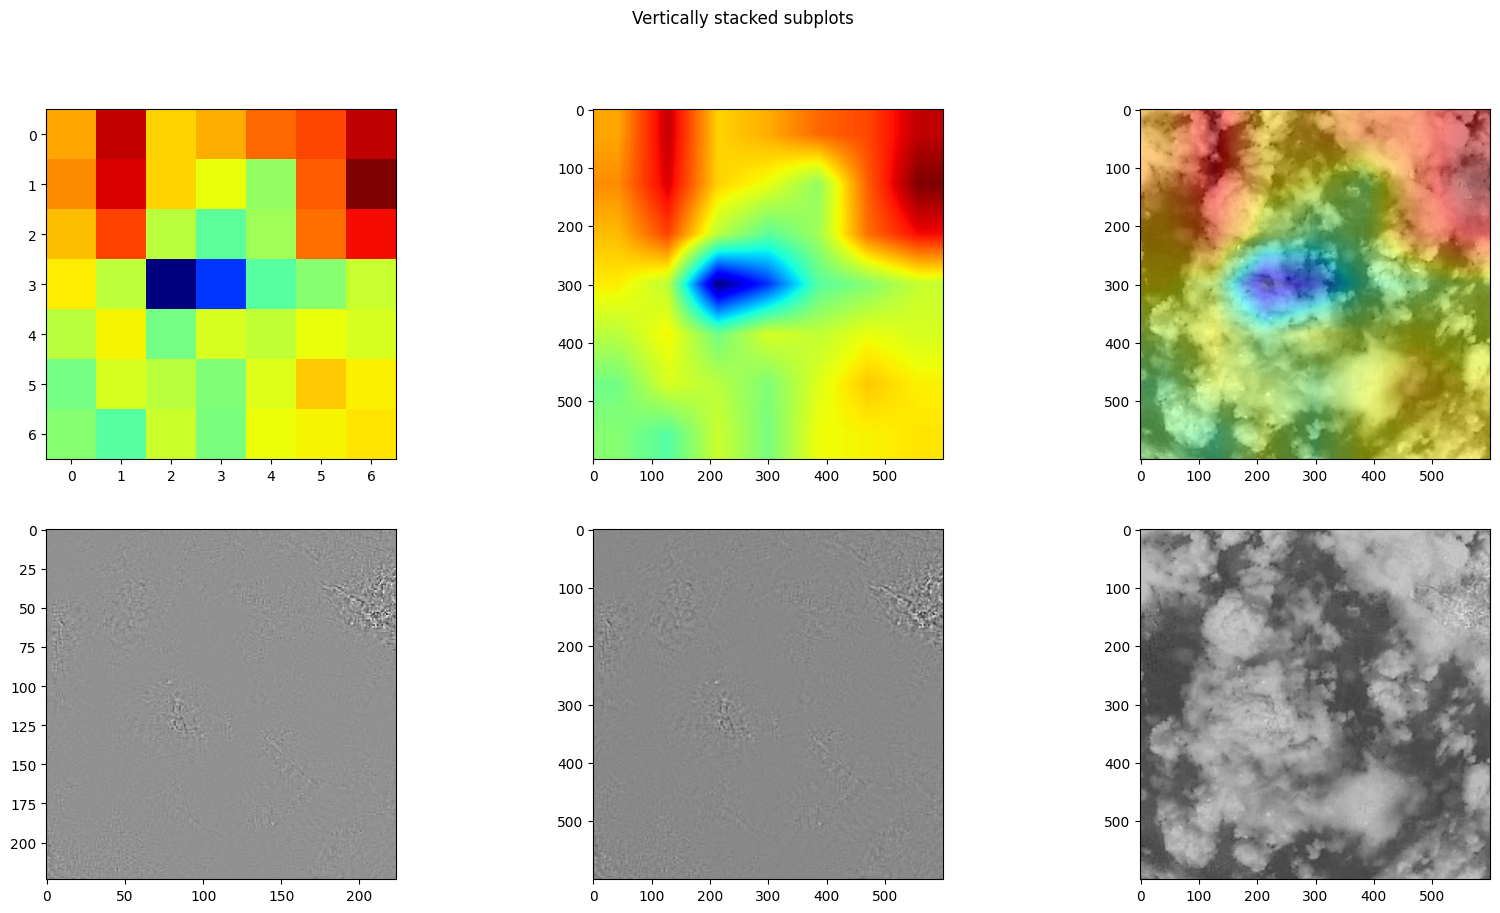

In [28]:
blob_img_path = "60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg"
model_name = "facebook/convnext-large-224"
gradient_maps, feature_maps = grad_feature_comparison(blob_img_path, model_name)


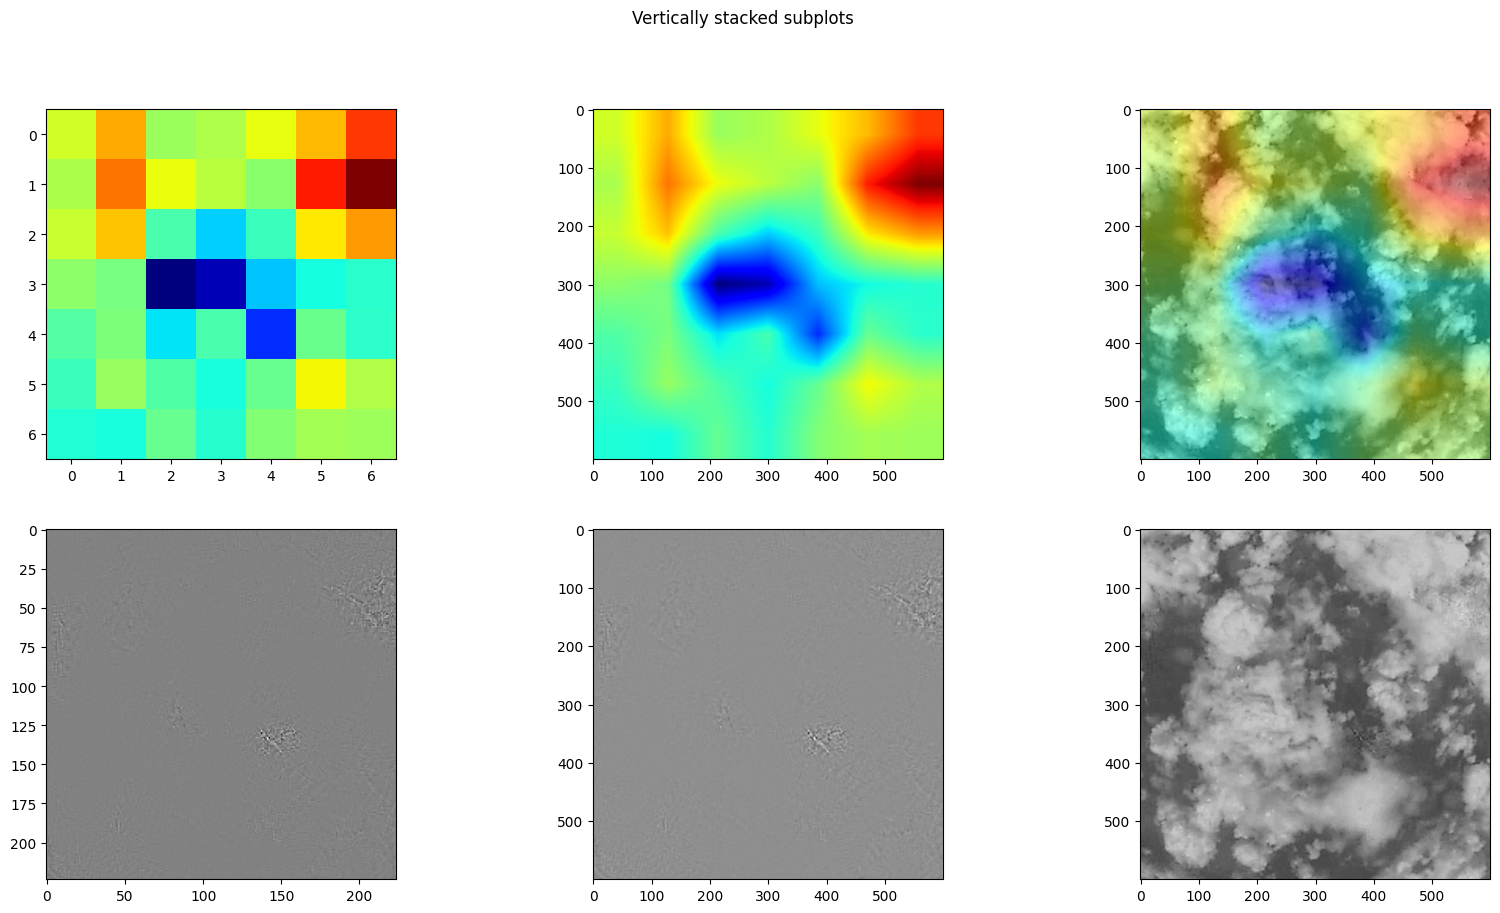

In [29]:
blob_img_path = "60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_1.jpg"
model_name = "facebook/convnext-large-224"
gradient_maps, feature_maps = grad_feature_comparison(blob_img_path, model_name)

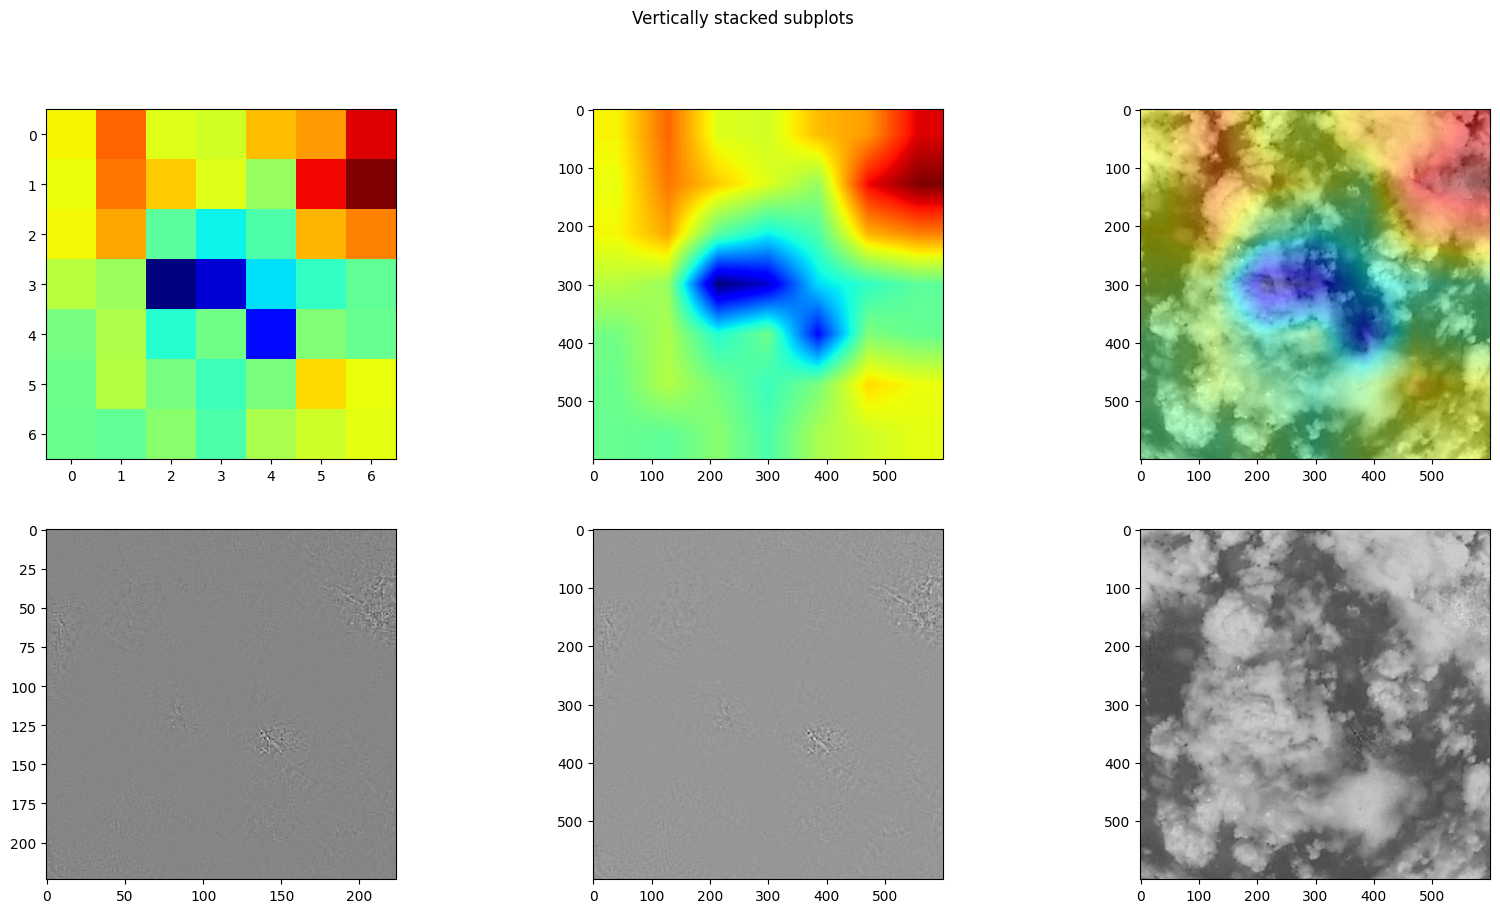

In [30]:
blob_img_path = "60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_2.jpg"
model_name = "facebook/convnext-large-224"
gradient_maps, feature_maps = grad_feature_comparison(blob_img_path, model_name)

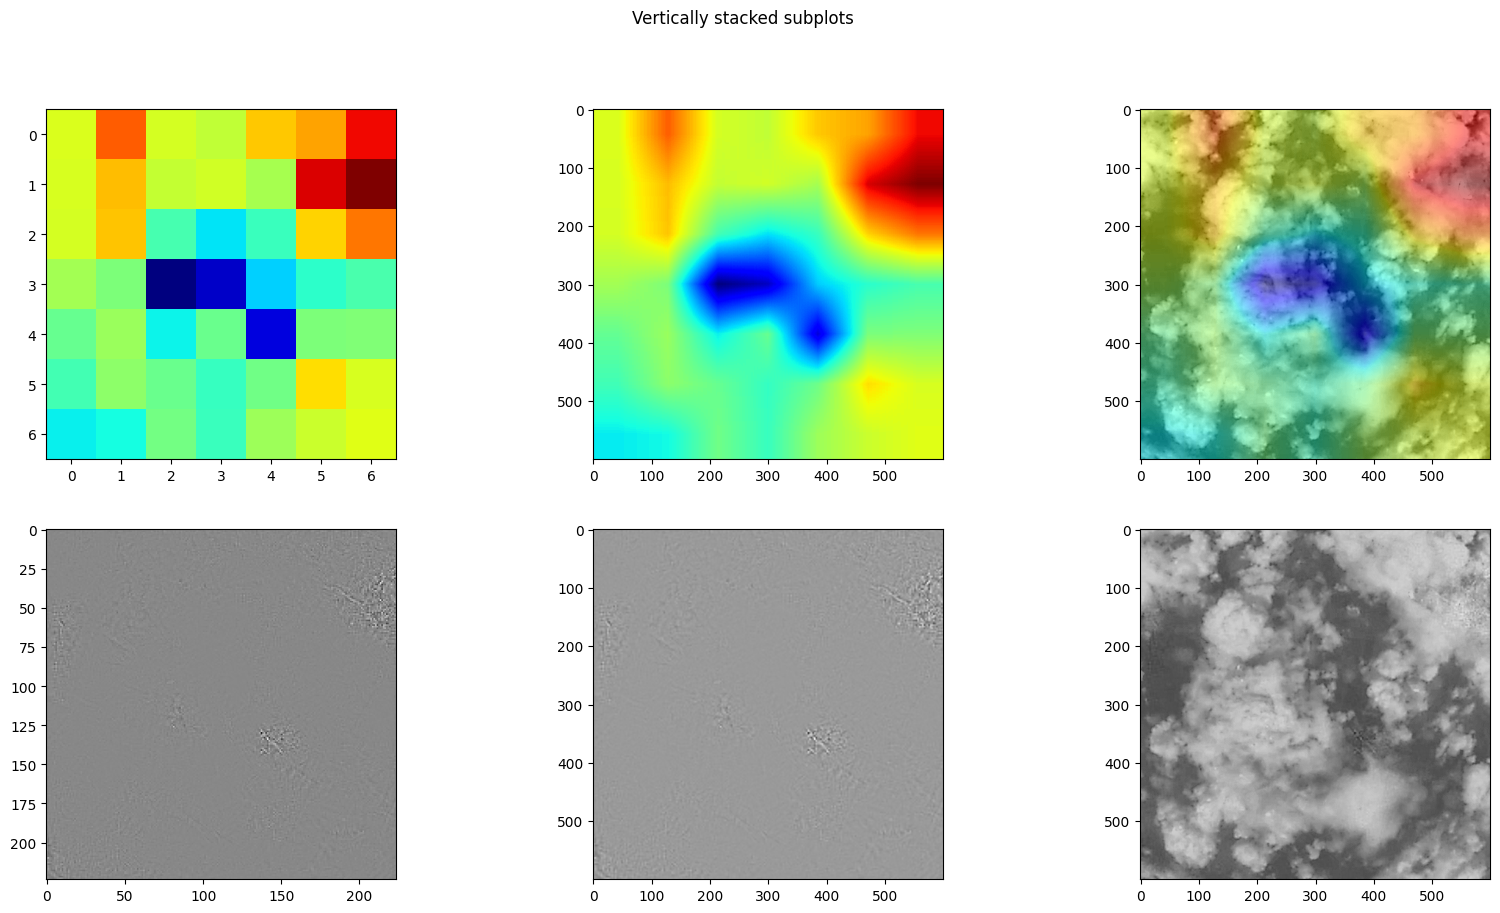

In [31]:
blob_img_path = "60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_3.jpg"
model_name = "facebook/convnext-large-224"
gradient_maps, feature_maps = grad_feature_comparison(blob_img_path, model_name)

## Analysis and Findings:

The above feature maps and gradient maps appear to correspond. The top row consists of feature maps raw, interpolates, and then super-imposed over the original image. The darker blues and reds correspond with the "wrinkles" in the gradient grayscale images in the second row of corresponding raw, interpolated, and super-imposed images.

The untrained out-of-the-box conv-next appears to be unsuitable for our cloud dataset as the highlighted important features appear to be arbitrary. For optical flow geometry models, we will likely use other methods to select good features to track, such as Shi-Tomasi.